***

# Popular Based Recommendations
### - dataset : [movielens 1m](https://grouplens.org/datasets/movielens/)
### - method : popular-based, MAB(Thompson Sampling)
### - feature : \[numeric\] implicit rating

***

## 0) Import library

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import beta

In [2]:
pd.options.display.float_format = '{:.4f}'.format

***

## 1) Data processing

### load data

In [3]:
movies = pd.read_csv('data/movie_lens/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings = pd.read_csv('data/movie_lens/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0000,964982703
1,1,3,4.0000,964981247
2,1,6,4.0000,964982224
3,1,47,5.0000,964983815
4,1,50,5.0000,964982931
...,...,...,...,...
100831,610,166534,4.0000,1493848402
100832,610,168248,5.0000,1493850091
100833,610,168250,5.0000,1494273047
100834,610,168252,5.0000,1493846352


### get popular N item by count(clicked)

In [5]:
N = 10
rating_counts = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
top_n_ids = rating_counts[:N].index
top_n_ids

Int64Index([356, 318, 296, 593, 2571, 260, 480, 110, 589, 527], dtype='int64', name='movieId')

In [6]:
top_n_items = movies[movies['movieId'].isin(top_n_ids)]['title'].values
top_n_items

array(['Braveheart (1995)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)',
       'Forrest Gump (1994)', 'Jurassic Park (1993)',
       "Schindler's List (1993)", 'Terminator 2: Judgment Day (1991)',
       'Silence of the Lambs, The (1991)', 'Matrix, The (1999)'],
      dtype=object)

### merge and drop

In [7]:
data = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left').drop(columns=['timestamp', 'movieId'])
data

,userId,rating,title
0,1,4.0000,Toy Story (1995)
1,1,4.0000,Grumpier Old Men (1995)
2,1,4.0000,Heat (1995)
3,1,5.0000,Seven (a.k.a. Se7en) (1995)
4,1,5.0000,"Usual Suspects, The (1995)"
...,...,...,...
100831,610,4.0000,Split (2017)
100832,610,5.0000,John Wick: Chapter Two (2017)
100833,610,5.0000,Get Out (2017)
100834,610,5.0000,Logan (2017)


***

## 2) Simulation

### define function for simulation

In [8]:
class TompsonSamplingSimulator:
    def __init__(self, history_df, user_colname, item_colname, reco_items, rating_colname, n_iter, n_visit):
        self.history = history_df
        self.user_col = user_colname
        self.item_col = item_colname
        self.reco_items = reco_items
        self.rating_col = rating_colname
        self.num_iter = n_iter
        self.num_visit = n_visit
        
        self.users = history_df[user_colname].unique()
        self.num_user = len(self.users)
        self.num_item = len(reco_items)
        
        self.alpha = None
        self.beta = None
        
        np.random.seed(seed=1234)
    
    def reset(self):
        self.alpha = np.ones(self.num_item)
        self.beta = np.ones(self.num_item)
    
    def select_arm(self):
        samples = [np.random.beta(a, b) for a, b in zip(self.alpha, self.beta)]
        
        return np.argmax(samples)
    
    def update_param(self, item_idx, reward):
        if reward==1:
            self.alpha[item_idx] += 1
        else:
            self.beta[item_idx] += 1
    
    def simulate(self):
        ret = {key:[] for key in ['iteration', 'visit', 'user_id', 'item', 'ctr']}
        
        for iteration in tqdm(range(1, self.num_iter+1)):
            
            self.reset()
            
            reward_total = 0
            
            for visit in range(1, self.num_visit+1):
                
                user_idx = np.random.randint(self.num_user)
                user_id = self.users[user_idx]
                
                item_idx = self.select_arm()
                item = self.reco_items[item_idx]
                
                rating = self.history.loc[(self.history[self.user_col]==user_id) &\
                                          (self.history[self.item_col]==item)][self.rating_col]
                
                if rating.shape[0]>0:
                    reward = 1
                else:
                    reward = 0
                
                self.update_param(item_idx, reward)
            
                reward_total += reward
                
                ctr = reward_total/visit
                
                ret['iteration'].append(iteration)
                ret['visit'].append(visit)
                ret['user_id'].append(user_id)
                ret['item'].append(item)
                ret['ctr'].append(ctr)
        
        return ret

### run simulator

In [9]:
simulator = TompsonSamplingSimulator(history_df=data,
                                     user_colname='userId',
                                     item_colname='title',
                                     reco_items=top_n_items,
                                     rating_colname='rating',
                                     n_iter=10,
                                     n_visit=1000)
result = simulator.simulate()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.30s/it]


### see result

In [10]:
result_df = pd.DataFrame(result)
result_df

,iteration,visit,user_id,item,ctr
0,1,1,295,Pulp Fiction (1994),1.0000
1,1,2,466,"Silence of the Lambs, The (1991)",0.5000
2,1,3,575,Jurassic Park (1993),0.3333
3,1,4,292,Star Wars: Episode IV - A New Hope (1977),0.5000
4,1,5,315,Pulp Fiction (1994),0.4000
...,...,...,...,...,...
9995,10,996,417,Braveheart (1995),0.5050
9996,10,997,165,Forrest Gump (1994),0.5045
9997,10,998,386,"Shawshank Redemption, The (1994)",0.5050
9998,10,999,52,Forrest Gump (1994),0.5055


### see distribution each items

In [11]:
alpha_list = simulator.alpha
beta_list = simulator.beta

In [12]:
x = np.linspace(0,0.99,1000)
samples = [beta.pdf(x, a, b) for a, b in zip(alpha_list, beta_list)]

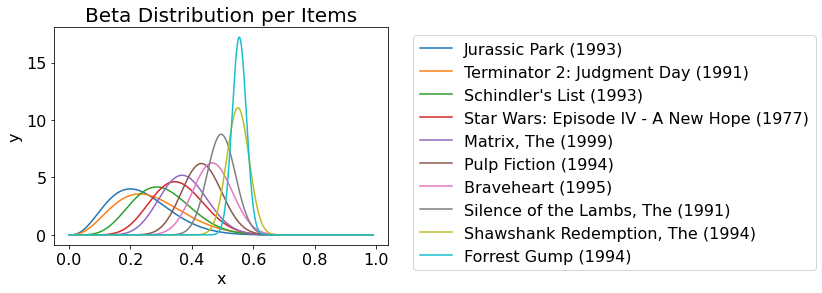

In [13]:
idx = np.argsort([s[10] for s in samples])[-1::-1]
for i in idx:
    plt.plot(x, samples[i], label=top_n_items[i])
plt.legend(bbox_to_anchor=(1.05, 1.0),fontsize=16)
plt.title('Beta Distribution per Items', fontsize=20)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

***

## 3) Visulaize Performane

### plot for Percentage of Clicked Recommendations

#### get most clicked item and ctr

In [14]:
baseline_item = top_n_items[0]
baseline_ctr = len(data.loc[data['title']==baseline_item])/len(data['userId'].unique())
print(f"most clicked item: {baseline_item}")
print(f"CTR for baseline item: {baseline_ctr}")

most clicked item: Braveheart (1995)
CTR for baseline item: 0.3885245901639344


#### calculate mean ctr per visit

In [15]:
mean_ctr = result_df.groupby('visit')['ctr'].mean()
mean_ctr

visit
1      0.4000
2      0.4000
3      0.3667
4      0.4000
5      0.3600
        ...  
996    0.4822
997    0.4820
998    0.4820
999    0.4821
1000   0.4822
Name: ctr, Length: 1000, dtype: float64

#### draw plot

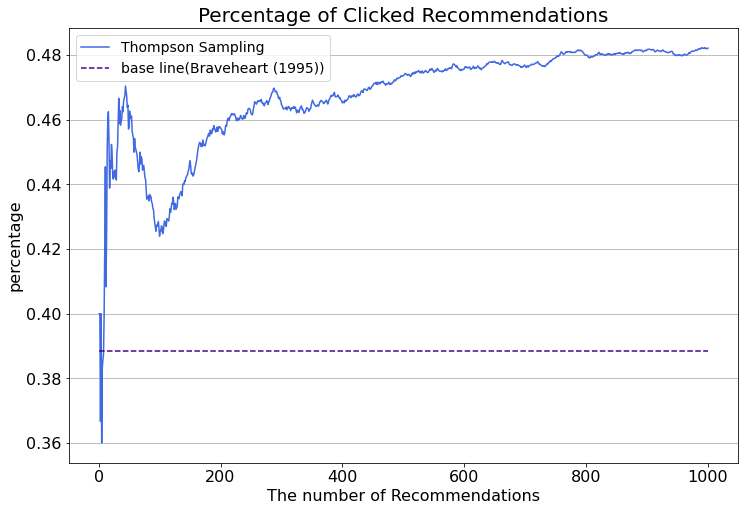

In [16]:
plt.rcParams['figure.figsize'] = [12, 8]

plt.plot(mean_ctr, color='royalblue', label='Thompson Sampling')
plt.hlines(baseline_ctr, min(mean_ctr.index), max(mean_ctr.index),
           color='indigo', linestyle='--', label=f'base line({baseline_item})')
plt.title('Percentage of Clicked Recommendations', fontsize=20)
plt.xlabel('The number of Recommendations', fontsize=16)
plt.ylabel('percentage', fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.grid(True, axis='y')
plt.show()

### Percentage of Recommendations per Items

#### get cumsum recommendations per items

In [17]:
cumsum_df = result_df[result_df['iteration']==1]
cumsum_df['clicked'] = 1
cumsum_df = cumsum_df.pivot(index='visit', columns='item', values='clicked')
cumsum_df = cumsum_df.fillna(0)
cumsum_df = cumsum_df.cumsum(axis=0)
cumsum_df = cumsum_df.div(cumsum_df.index/100, axis=0)
cumsum_df

C:\Users\HS\anaconda3\envs\reco_sys\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


item,Braveheart (1995),Forrest Gump (1994),Jurassic Park (1993),"Matrix, The (1999)",Pulp Fiction (1994),Schindler's List (1993),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Terminator 2: Judgment Day (1991)
visit,,,,,,,,,,
1,0.0000,0.0000,0.0000,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,50.0000,0.0000,0.0000
3,0.0000,0.0000,33.3333,0.0000,33.3333,0.0000,0.0000,33.3333,0.0000,0.0000
4,0.0000,0.0000,25.0000,0.0000,25.0000,0.0000,0.0000,25.0000,25.0000,0.0000
5,0.0000,0.0000,20.0000,0.0000,40.0000,0.0000,0.0000,20.0000,20.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...
996,5.9237,1.8072,7.3293,5.1205,10.9438,0.9036,40.8635,14.0562,10.9438,2.1084
997,5.9178,1.8054,7.3220,5.1153,10.9328,0.9027,40.8225,14.0421,11.0331,2.1063
998,5.9118,1.8036,7.3146,5.1102,10.9218,0.9018,40.8818,14.0281,11.0220,2.1042


#### draw plot

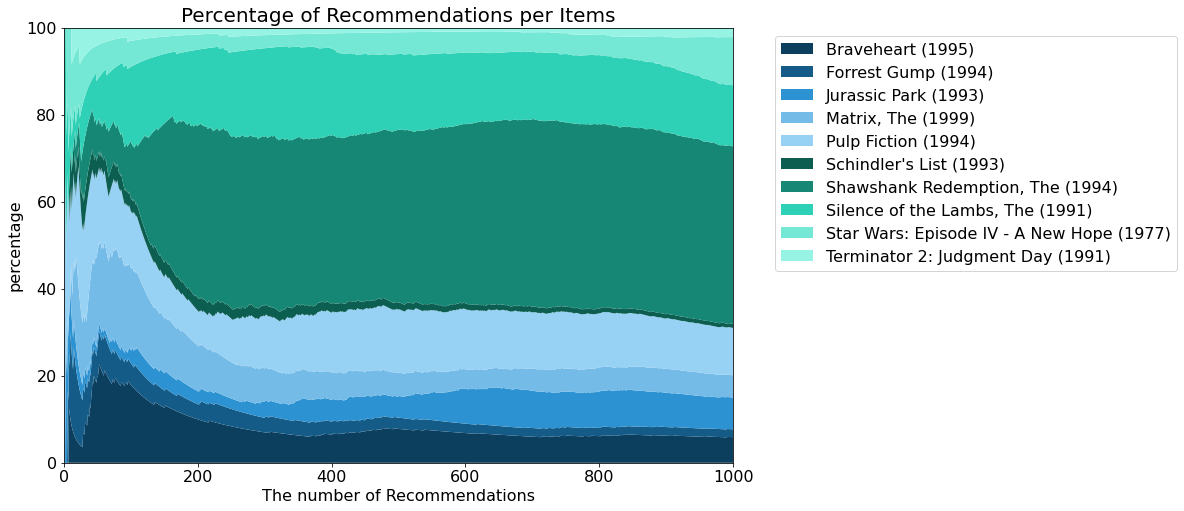

In [18]:
colors = ["0c3e5e","155b87","2d92d1","74bbe8","97d1f4","0c5e50","158774","2ed1b5","74e8d4","97f4e5"]
color_dict = dict(zip(top_n_items, colors))

plt.stackplot(cumsum_df.index, cumsum_df.values.T,
              labels=cumsum_df.columns,
              colors=colors)
plt.xlim(0,1000)
plt.ylim(0,100)
plt.title('Percentage of Recommendations per Items', fontsize=20)
plt.xlabel('The number of Recommendations', fontsize=16)
plt.ylabel('percentage', fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.05, 1.0),fontsize=16, loc='upper left')
plt.show()